<a href="https://colab.research.google.com/github/kangtaeksu/Trio/blob/main/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Category 4

RNN 을 활용한 텍스트 분류 (Text Classification)

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

NLP QUESTION

For this task you will build a classifier for the sarcasm dataset
The classifier should have a final layer with 1 neuron activated by sigmoid as shown.<br/><br/>
It will be tested against a number of sentences that the network hasn't previously seen<br/>
And you will be scored on whether sarcasm was correctly detected in those sentences


-------------------------------
**자연어 처리**<br/><br/>
이 작업에서는 sarcasm 데이터 세트에 대한 분류기를 작성합니다.
분류기는 1 개의 뉴런으로 이루어진 sigmoid 활성함수로 구성된 최종 층을 가져야합니다.<br/>
제출될 모델은 데이터셋이 없는 여러 문장에 대해 테스트됩니다.
그리고 당신은 그 문장에서 sarcasm 판별이 제대로 감지되었는지에 따라 점수를 받게 될 것입니다


-----------------------------------


## 필요한 모듈 import

In [ ]:
import json
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

## 필요한 데이터 셋 다운로드

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json') # json 파일로 받아들임

('sarcasm.json', <http.client.HTTPMessage at 0x7fd4d9f11278>)

## Json 파일 로드

`datas` 변수에 `json`을 활용하여 로드

In [ ]:
with open('sarcasm.json') as f:
    datas = json.load(f)

In [ ]:
print(len(datas)) # 데이터 전ㄴ체 26,709 개!

26709


`datas` 5개  출력

* `article_link`: 뉴스 기사 URL
* `headline`: 뉴스기사의 제목
* `is_sarcastic`: 비꼬는 기사 여부 (비꼼: 1, 일반: 0)

In [ ]:
datas[:5] # 아래 결과 중 article link는 실제 신문 기사이므로 그것까지 쓰지 않고 제목만 갖고 비꼬는지 아닌지를 판단할 것임

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

## 전처리: 데이터셋 구성(sentences, labels)

* X (Feature): sentences
* Y (Label): label

빈 list를 생성합니다. (sentences, labels)

In [ ]:
sentences = []
labels = []

In [ ]:
for data in datas:
    sentences.append(data['headline'])
    labels.append(data['is_sarcastic'])

문장 5개를 출력합니다.

In [ ]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [ ]:
labels[:5]

[0, 0, 1, 1, 0]

## Train / Validation Set 분리

20,000개를 기준으로 **데이터셋을 분리**합니다.


In [ ]:
training_size = 20000

In [ ]:
train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

In [ ]:
validation_sentences = sentences[training_size:]
validation_labels = labels[training_size:]

## 전처리 Step 1. Tokenizer 정의

단어의 토큰화를 진행합니다.

* `num_words`: 단어 max 사이즈를 지정합니다. 가장 **빈도수가 높은** 단어부터 저장합니다.
* `oov_token`: 단어 토큰에 없는 단어를 어떻게 표기할 것인지 지정해줍니다.

In [ ]:
# 이 내역은 변경하면 안됨, 시험에 지정됨
vocab_size = 1000 # 전체 단어를 토큰화한 것 중 1000개만 사용할 것임. 빈도수가 높은 것을 기반으로!
oov_tok = "<OOV>" # Out of vocal 으로 신조어는 치환 시킨다는 것임

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # 토크나이저 스펙 정의

## 전처리 Step 2. Tokenizer로 학습시킬 문장에 대한 토큰화 진행

`fit_on_texts`로 학습할 문장에 대하여 **토큰화**를 진행합니다.

In [ ]:
tokenizer.fit_on_texts(train_sentences) # train_sentence는 뉴스 기사 문장으로 이걸 가지고 사전을 만들게 됨

In [ ]:
for key, value in tokenizer.word_index.items():
    print('{}  \t======>\t {}'.format(key, value))
    if value == 25:
        break

<OOV>  	======>	 1
to  	======>	 2
of  	======>	 3
the  	======>	 4
in  	======>	 5
for  	======>	 6
a  	======>	 7
on  	======>	 8
and  	======>	 9
with  	======>	 10
is  	======>	 11
new  	======>	 12
trump  	======>	 13
man  	======>	 14
from  	======>	 15
at  	======>	 16
about  	======>	 17
you  	======>	 18
by  	======>	 19
this  	======>	 20
after  	======>	 21
be  	======>	 22
up  	======>	 23
out  	======>	 24
that  	======>	 25


토큰화된 **단어 사전의 갯수**

In [ ]:
len(tokenizer.word_index) # 단어 사전 개수가 25637개로 만들어졌음.
# 근데 vocab 사이즈를 1000으로 했는데?
# 왜냐면 사전을 만들때는 우선 다 만들게됨, 치환하는 과정에서 1000 이하의 빈도수를 OOV로 치환하는 것임

25637

단어사전은 **dictionary** 형태로 되어 있습니다. 

즉, 단어를 key로 입력하면 값을 return 합니다.

In [ ]:
word_index = tokenizer.word_index # 각 단어의 토큰 순서를 가져옴

In [ ]:
word_index

{'<OOV>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'by': 19,
 'this': 20,
 'after': 21,
 'be': 22,
 'up': 23,
 'out': 24,
 'that': 25,
 'how': 26,
 'as': 27,
 'it': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'what': 32,
 'his': 33,
 'all': 34,
 'he': 35,
 'will': 36,
 'who': 37,
 'just': 38,
 'has': 39,
 'more': 40,
 'one': 41,
 'year': 42,
 'into': 43,
 'report': 44,
 'have': 45,
 'why': 46,
 'over': 47,
 'area': 48,
 'u': 49,
 'donald': 50,
 'says': 51,
 'day': 52,
 'can': 53,
 's': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'like': 58,
 'get': 59,
 'old': 60,
 'no': 61,
 'her': 62,
 "trump's": 63,
 'off': 64,
 'now': 65,
 'an': 66,
 'obama': 67,
 'life': 68,
 'people': 69,
 'women': 70,
 'house': 71,
 "'": 72,
 'was': 73,
 'still': 74,
 'white': 75,
 'back': 76,
 'make': 77,
 'than': 78,
 'clinton': 79,
 'down': 80,
 'when': 8

In [ ]:
word_index['trump']

13

In [ ]:
word_index['hello']

11724

In [ ]:
word_index['<OOV>']

1

## 전처리 Step 3. 문장(sentences)을 토큰으로 변경 (치환)

`texts_to_sequences`: 문장을 숫자로 **치환** 합니다. Train Set, Valid Set 모두 별도로 적용해주어야 합니다.

In [ ]:
# 문장을 숫자로 치환!
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)

**변환된 Sequences 확인**

In [ ]:
train_sequences[:5]

[[328, 1, 799, 1, 1, 47, 389, 1, 1, 6, 1, 1],
 [4, 1, 1, 1, 23, 2, 161, 1, 390, 1, 6, 251, 9, 889],
 [153, 890, 2, 891, 1, 1, 595, 1, 221, 133, 36, 45, 2, 1],
 [1, 38, 213, 382, 2, 1, 29, 288, 23, 10, 1, 1, 1, 958],
 [715, 672, 1, 1, 1, 662, 553, 5, 4, 92, 1, 90]]

변환 과정에서 '<OOV>'로 **변환된 단어** 확인

빈도수로 지정한 `num_words`=1000 에 의거하여, 빈도수가 1000번째보다 떨어지는 단어는 자동으로 1로 치환됩니다.

1은 '<OOV>' 입니다. (Out of Vocab)

In [ ]:
train_sentences[4]

'j.k. rowling wishes snape happy birthday in the most magical way'

In [ ]:
word_index['j'], word_index['k'], word_index['rowling'], word_index['wishes'], word_index['snape'], word_index['happy']

(715, 672, 5652, 1043, 8865, 662)

In [ ]:
train_sequences[4] # 'rowling, wishes, snape 등은 빈도수가 1000번 보다 낮아서 OOV가 됨,

[715, 672, 1, 1, 1, 662, 553, 5, 4, 92, 1, 90]

## 전처리 Step 4. 시퀀스의 길이를 맞춰주기

3가지 옵션을 입력해 줍니다.

* `maxlen`: 최대 문장 길이를 정의합니다. 최대 문장길이보다 길면, 잘라냅니다.
* `truncating`: 문장의 길이가 `maxlen`보다 길 때 앞을 자를지 뒤를 자를지 정의합니다.
* `padding`: 문장의 길이가 `maxlen`보다 짧을 때 채워줄 값을 앞을 채울지, 뒤를 채울지 정의합니다.

In [ ]:
# 한 문장의 최대 단어 숫자, 기준이 될 문장의 길이를 지정. 120으로 했으면 한 문장에 대해 120단어가 올 수 있다고 정의한거임
max_length = 120

# 잘라낼 문장의 위치
# 120단어보다 더 길 때, 뒤를 잘라낼거면 post, 앞은 pre
trunc_type='post'

# 채워줄 문장의 위치
# 문장이 짧을 때 앞을 채울 거면 pre, 뒤는 post
padding_type='post'

In [ ]:
# q방금 변환한 sequence에서 길이에 맞추어 모든 문장에 대해 padding 또는 truncating을 수행함
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

변환된 후 shape 확인

In [ ]:
train_padded.shape

(20000, 120)

## 전처리 Step 5. label 값을 numpy array로 변환

model이 `list` type은 받아들이지 못하므로, numpy array로 변환합니다.

In [ ]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

-------------------------------------------------------------


## Embedding Layer

**고차원을 저차원으로 축소**시켜주는 역할을 합니다.

one-hot encoding을 진행했을 때, 1000차원으로 표현되는 단어들을 16차원으로 줄여주는 겁니다. 그렇게 해서 `sparsity`문제를 해소하도록 유도합니다.

In [ ]:
 # embedding을 하는 이유는 만약 1000차원으로 넣게 되면 각 단어가 독립적인 상태로 보이기 때문에 관계를 파악할 수 없음
 # 예를 들어, boy / girl은 유사한 단어인데 이에 대한 인식을 못하게 됨!
 # 또한 One-Hot encoding 시 ,각 문장이 대부분이 0으로 되어 있을 것이고 나머지는 1일 것이니까 연산이 매우 비효율적일 것임
 # 그래서 embedding layer를 쓰는 것임
 # 그래서 embedding을 통해 비슷한 단어는 유사한 위치에 있게 되고 반대되는 단어는 반대의 위치에 있게 됨!(성별, 시제, 국가-수도 등 관계를 알 수 있음)
 # 아래 변환할 차원은 시험에 주어짐
embedding_dim = 16

**변환 전**

In [ ]:
sample = np.array(train_padded[0])
sample

array([328,   1, 799,   1,   1,  47, 389,   1,   1,   6,   1,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

**변환 후**

In [ ]:
x = Embedding(vocab_size, embedding_dim, input_length=max_length)
x(sample)[0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 0.02789031,  0.01896976, -0.03223661, -0.02024066,  0.02604628,
        0.00789473, -0.00013664,  0.02064439,  0.02467037,  0.04920587,
        0.00449502,  0.01197068, -0.01727673, -0.03491609, -0.0279251 ,
       -0.02350136], dtype=float32)>

## 모델 정의 (Sequential)

In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

요약 확인

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,961
Trainable params: 160,961
Non-trainable params: 0
__________________________________________________

## 컴파일 (compile)

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`는 이진 분류이기 때문에 `binary_crossentropy`를 사용합니다.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## ModelCheckpoint: 체크포인트 생성

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [ ]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

## 학습 (fit)

In [ ]:
epochs=10

In [ ]:
history = model.fit(train_padded, train_labels, 
                    validation_data=(validation_padded, validation_labels),
                    callbacks=[checkpoint],
                    epochs=epochs)

Epoch 1/10
624/625 [============================>.] - ETA: 0s - loss: 0.4420 - acc: 0.7813
Epoch 00001: val_loss improved from inf to 0.39250, saving model to my_checkpoint.ckpt
625/625 [==============================] - 17s 27ms/step - loss: 0.4419 - acc: 0.7814 - val_loss: 0.3925 - val_acc: 0.8231
Epoch 2/10
624/625 [============================>.] - ETA: 0s - loss: 0.3532 - acc: 0.8406
Epoch 00002: val_loss improved from 0.39250 to 0.37367, saving model to my_checkpoint.ckpt
625/625 [==============================] - 16s 25ms/step - loss: 0.3533 - acc: 0.8407 - val_loss: 0.3737 - val_acc: 0.8246
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.3254 - acc: 0.8559
Epoch 00003: val_loss did not improve from 0.37367
625/625 [==============================] - 16s 25ms/step - loss: 0.3256 - acc: 0.8558 - val_loss: 0.3827 - val_acc: 0.8234
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.3078 - acc: 0.8658
Epoch 00004: val_loss did not improve 

## 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

In [ ]:
model.load_weights(checkpoint_path)

## 학습 오차에 대한 시각화

In [ ]:
import matplotlib.pyplot as plt

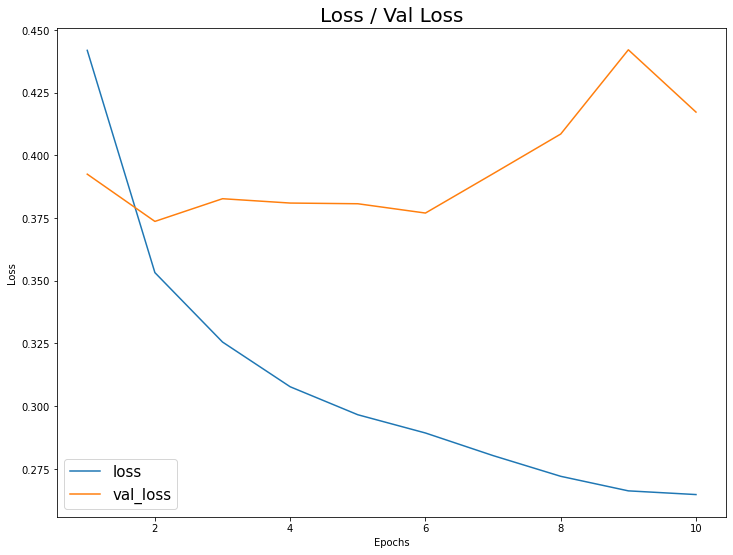

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

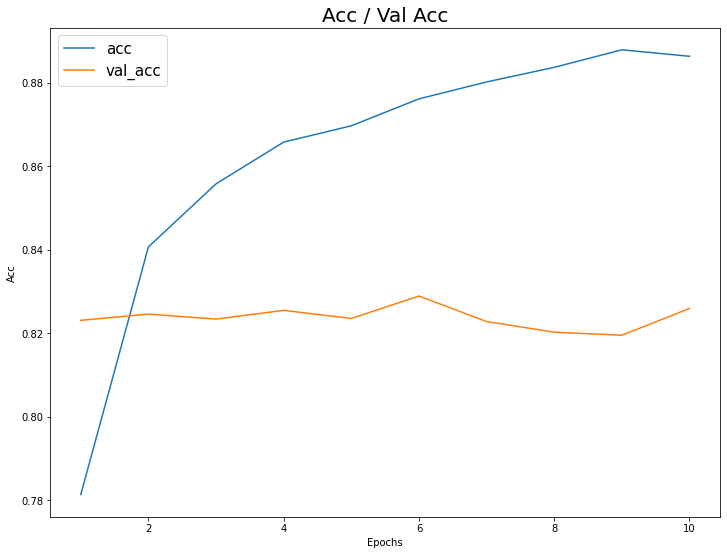

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()